In [84]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

In [85]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
#i case==2 dname=data_C.... implement on our own if we want

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

print(v.shape)

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
[0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0]
...
(10000, 20)


## initialize

In [86]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 2
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-8.72876393e-02  2.04222126e-01]
 [-2.21489412e-01 -2.36964198e-01]
 [ 8.38211653e-01  5.94150244e-01]
 [ 3.96160518e-02  1.20136963e-01]
 [ 3.27912325e-01  5.31481557e-01]
 [ 4.29466985e-01 -5.52710538e-01]
 [ 1.17256826e-01  9.76087795e-02]
 [ 5.76885677e-01  3.77974741e-01]
 [-8.53501017e-01 -1.58554191e-01]
 [ 7.11674783e-01 -1.87006764e-01]
 [-2.30146526e-01  2.03387092e-01]
 [ 1.38535434e+00 -4.35452880e-01]
 [-2.46070853e-01  5.29254898e-02]
 [ 1.29034856e-01  2.23337160e-01]
 [ 4.00935791e-04  5.73002421e-01]
 [-3.04256178e-01 -3.54405060e-01]
 [-1.01067017e+00 -7.93431066e-01]
 [-3.67028188e-01  2.38846755e-01]
 [-5.39796281e-01  5.10944576e-02]
 [-4.53483232e-01  1.41941667e-01]]
a= [-1.00605956 -0.0850854  -0.6575091  -0.41392318 -0.55731957  0.12209994
  0.16117297 -0.3214583   0.14126068  0.57553201  0.02979552  0.10518219
 -0.0050578   0.4284531   0.56591768 -0.39197445 -0.6605412   0.00945954
  0.32336713 -0.28164852]
b= [0. 0.]


## Plotting

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


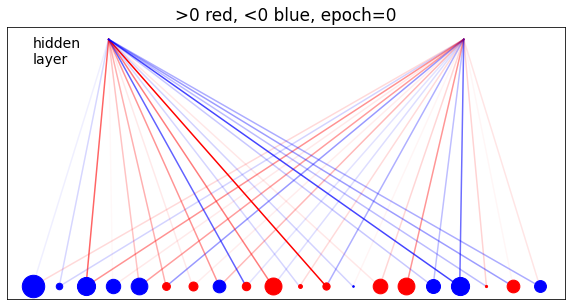

In [87]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [88]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 9
activate(v[k],w,b,GAP,info=True)

input= [0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
act= [-0.27337957  1.12943723]
prob= [0.4320776  0.75573503]
output= [0 0]


array([0, 0])

## Point 4:

If we simply use the activate function for the backward step of the contrastive divergence, we would generate vectors with 0s and 1s (activating a 1 for each component of the new vector, if a random generated number is under the probability calculated above). If we do so, however, for each 4 blocks of the vector there are $2^4$ possible states, while fot the way in which our data is structured (one-hot encoding) the ''real'' possible states are only 4: 0001,0010,0100,1000.    

Here is what I did:
- I defined a vector that contains all possible states, $s$
- for each entry of our data (a row with 20 elements) I divide it in blocks of 4;
- I compared each block of 4 with each state of s, to recognize to which state it corresponds;
- I compute the energy of the state as  $$E_{state}= \sum_{k \in block}[a_{k}+ \sum_{\nu}W_{k \nu}h_{\nu}]v_{k}$$
  where $v_{k}$ is (each time) the sub-vector of our real vector v constituded by 4 elements;

- I computed the Boltzmann's weights for each of the 4 states as $exp^{-E_{state}}$
- I calculated the normalized probability $p$.

Then, in order to have 4 intervals between 0 and 1, I calculated the cumulative probability for each state: $${C_{prob}}_i=\sum_{j\leq i}p_j$$.    
    
At this point, I have 4 levels that divide the gap 0-1 into 4 intervals. I generate a random number between 0 and 1 and, depending on which interval it belongs, I then generate the corresponding state of s.    
In this way, I generate 4 blocks at a time of the new "fantasy" vector (so I do it $5$ times), preserving the one-hot encoding structure.

In [89]:
s = np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
vtest = np.array([0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0])
print(vtest)
htest = np.array([0, 1])  


def activate_back(v,h,w,a,k,steps):
    
    e = np.zeros(4)
    
    for i in range(0,20,4):
        for j in range(len(s)):
            if np.array_equiv(v[i:i+4],s[j])==True:
                local_f = a[i:i+4]+np.dot(h,w[:,i:i+4])
                e[j]+= np.dot(local_f,v[i:i+4])
    b = exp(e)
    p = b/b.sum()
    #print(p)
    cprob = np.zeros(4)
    cprob[0] = p[0]
    for i in range(1,4):
        cprob[i]+=cprob[i-1]+p[i]
        
    vf = np.zeros(20)
    for i in range(0,20,4):
        x = np.random.random()
        if x<=cprob[0]:
            vf[i:i+4]=s[0]
        if cprob[0]<x<=cprob[1]:
            vf[i:i+4]=s[1]
        if cprob[1]<x<=cprob[2]:
            vf[i:i+4]=s[2]
        if cprob[2]<x<=cprob[3]:
            vf[i:i+4]=s[3]
            
    for i in range(0,2):
        if k == 500*i and steps==1:
            print('----initiating backward CD: k = ',k,'----')
            print('WEIGHTS[0] : ', w.T[0])
            print('EVALUATED ENERGIES = ',e, '\n') 
            print('PROBABILITY : ', p, '\n')                       #it starts to behave strangely after 4,5 epochs
            print('CUMULATIVE PROBABILITY : ', cprob, '\n\n')
            
    return(vf,cprob)

vf, cprob = activate_back(vtest,htest,w.T,a,1,1)
print(vf)
print(cprob)

[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
[0.17803597 0.48485895 0.82650521 1.        ]


# Training with ADAM and more steps of CD

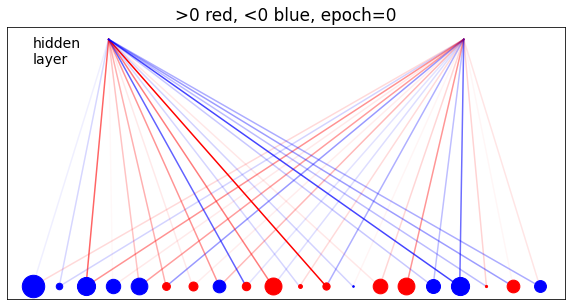

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.08728764  0.20422213]
EVALUATED ENERGIES =  [ 0.         -0.2360776   0.55748796 -0.22940725] 

PROBABILITY :  [0.23089333 0.18234094 0.40320446 0.18356128] 

CUMULATIVE PROBABILITY :  [0.23089333 0.41323426 0.81643872 1.        ] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-0.08728764  0.20422213]
EVALUATED ENERGIES =  [0.63340212 1.13932104 0.43793913 0.        ] 

PROBABILITY :  [0.24926805 0.41341327 0.20501145 0.13230723] 

CUMULATIVE PROBABILITY :  [0.24926805 0.66268132 0.86769277 1.        ] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-0.08728764  0.20422213]
EVALUATED ENERGIES =  [ 0.10518219 -0.33414197  0.4284531  -0.55731957] 

PROBABILITY :  [0.28235257 0.18196828 0.39010949 0.14556966] 

CUMULATIVE PROBABILITY :  [0.28235257 0.46432085 0.85443034 1.        ] 


----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-0.08928764  0.20222213]
EVALUATED ENERGIES =  [-0.41523356  0.    

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-0.24390724  0.04320212]
EVALUATED ENERGIES =  [-0.21757976  0.35827627  1.77641066  0.        ] 

PROBABILITY :  [0.08797782 0.15648197 0.6461781  0.10936211] 

CUMULATIVE PROBABILITY :  [0.08797782 0.24445979 0.89063789 1.        ] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-0.24610863  0.04116233]
EVALUATED ENERGIES =  [-0.7219909   0.91791268  0.88605737 -1.02562836] 

PROBABILITY :  [0.0841336  0.43368116 0.42008384 0.0621014 ] 

CUMULATIVE PROBABILITY :  [0.0841336  0.51781476 0.9378986  1.        ] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.28766606  0.0019203 ]
EVALUATED ENERGIES =  [ 0.          0.61117777  2.79454282 -0.66849468] 

PROBABILITY :  [0.05073508 0.09348447 0.82977977 0.02600068] 

CUMULATIVE PROBABILITY :  [0.05073508 0.14421954 0.97399932 1.        ] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-0.28766606  0.0019203 ]
EVALUATED ENERGIES =  [-1.27720175  0

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-0.48808019 -0.18881948]
EVALUATED ENERGIES =  [-2.17731962  1.67809047  1.17511566 -4.13282318] 

PROBABILITY :  [0.01299347 0.61391551 0.37125253 0.00183849] 

CUMULATIVE PROBABILITY :  [0.01299347 0.62690898 0.99816151 1.        ] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-0.49062774 -0.19113442]
EVALUATED ENERGIES =  [-0.5009365   2.45140791  0.         -7.82176281] 

PROBABILITY :  [4.58679279e-02 8.78407442e-01 7.56942829e-02 3.03469222e-05] 

CUMULATIVE PROBABILITY :  [0.04586793 0.92427537 0.99996965 1.        ] 




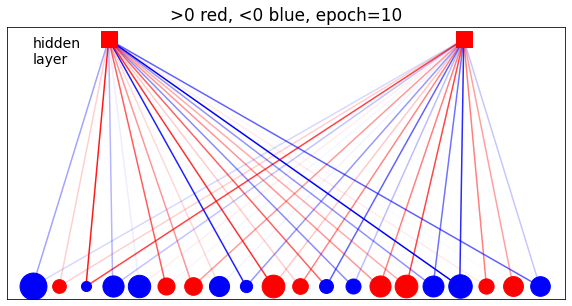

l_rate =  0.9090909090909092
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.53525524 -0.23292131]
EVALUATED ENERGIES =  [-2.39674644  2.20246997  0.         -2.51154418] 

PROBABILITY :  [0.00890588 0.88530186 0.09785225 0.00794001] 

CUMULATIVE PROBABILITY :  [0.00890588 0.89420774 0.99205999 1.        ] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-0.53525524 -0.23292131]
EVALUATED ENERGIES =  [-0.64396228  2.58237831  4.78196148  0.        ] 

PROBABILITY :  [0.00391677 0.09865291 0.88997276 0.00745757] 

CUMULATIVE PROBABILITY :  [0.00391677 0.10256967 0.99254243 1.        ] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-0.53525524 -0.23292131]
EVALUATED ENERGIES =  [-4.07275684  0.          0.         -2.51154418] 

PROBABILITY :  [0.00811676 0.47660507 0.47660507 0.03867309] 

CUMULATIVE PROBABILITY :  [0.00811676 0.48472184 0.96132691 1.        ] 


----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-0.53765033 -0.23516615]
EVALUATED

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.76306115 -0.45466517]
EVALUATED ENERGIES =  [0.         7.03404677 5.1632782  0.        ] 

PROBABILITY :  [7.62573394e-04 8.65225570e-01 1.33249283e-01 7.62573394e-04] 

CUMULATIVE PROBABILITY :  [7.62573394e-04 8.65988143e-01 9.99237427e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-0.76306115 -0.45466517]
EVALUATED ENERGIES =  [-4.41204729  0.          3.66668212 -2.87102506] 

PROBABILITY :  [3.01819346e-04 2.48814031e-02 9.73407474e-01 1.40930349e-03] 

CUMULATIVE PROBABILITY :  [3.01819346e-04 2.51832224e-02 9.98590697e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-0.76306115 -0.45466517]
EVALUATED ENERGIES =  [-3.43390153  1.98822073  0.         -3.78799658] 

PROBABILITY :  [0.00386014 0.87377679 0.119654   0.00270908] 

CUMULATIVE PROBABILITY :  [0.00386014 0.87763693 0.99729092 1.        ] 


----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-0.

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-0.92875894 -0.61555573]
EVALUATED ENERGIES =  [0.         8.45765867 6.22521764 0.        ] 

PROBABILITY :  [1.91631527e-04 9.02779000e-01 9.68377366e-02 1.91631527e-04] 

CUMULATIVE PROBABILITY :  [1.91631527e-04 9.02970632e-01 9.99808368e-01 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-0.93066056 -0.61740011]
EVALUATED ENERGIES =  [ -1.88039355   3.72549814   0.         -11.73439441] 

PROBABILITY :  [3.57678713e-03 9.72973306e-01 2.34497188e-02 1.87912165e-07] 

CUMULATIVE PROBABILITY :  [0.00357679 0.97655009 0.99999981 1.        ] 




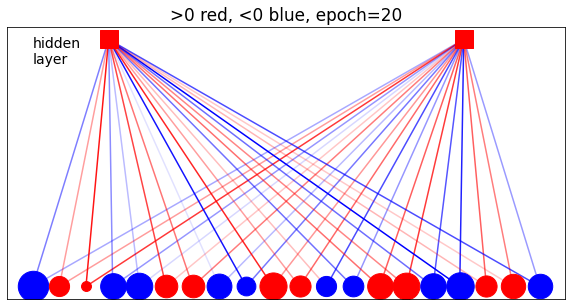

l_rate =  0.8333333333333337
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-0.96534387 -0.65137268]
EVALUATED ENERGIES =  [-1.98775819  3.82460187  8.82178893  0.        ] 

PROBABILITY :  [2.00667192e-05 6.71045974e-03 9.93123004e-01 1.46470036e-04] 

CUMULATIVE PROBABILITY :  [2.00667192e-05 6.73052646e-03 9.99853530e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-0.96534387 -0.65137268]
EVALUATED ENERGIES =  [-1.98775819  6.57614479  0.         -8.55801544] 

PROBABILITY :  [1.90570934e-04 9.98418156e-01 1.39100623e-03 2.67073129e-07] 

CUMULATIVE PROBABILITY :  [1.90570934e-04 9.98608727e-01 9.99999733e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-0.96534387 -0.65137268]
EVALUATED ENERGIES =  [-1.98775819  3.82460187  6.53774497 -3.47108627] 

PROBABILITY :  [1.85964955e-04 6.21880603e-02 9.37583783e-01 4.21919804e-05] 

CUMULATIVE PROBABILITY :  [1.85964955e-04 6.23740253e-02 9.99957808e-01 1.00000000e+00

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-1.11732281 -0.79939043]
EVALUATED ENERGIES =  [-7.17194819  3.18081904  4.0983767  -2.65557408] 

PROBABILITY :  [9.09962449e-06 2.85215520e-01 7.13942736e-01 8.32644899e-04] 

CUMULATIVE PROBABILITY :  [9.09962449e-06 2.85224619e-01 9.99167355e-01 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-1.11912789 -0.80115654]
EVALUATED ENERGIES =  [ 0.          7.72386722 10.26734873  0.        ] 

PROBABILITY :  [3.22152721e-05 7.28609309e-02 9.27074639e-01 3.22152721e-05] 

CUMULATIVE PROBABILITY :  [3.22152721e-05 7.28931462e-02 9.99967785e-01 1.00000000e+00] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.15124805 -0.83271701]
EVALUATED ENERGIES =  [-6.80328503  0.          7.33835615 -5.64569181] 

PROBABILITY :  [7.21239844e-07 6.49694003e-04 9.99347290e-01 2.29517634e-06] 

CUMULATIVE PROBABILITY :  [7.21239844e-07 6.50415243e-04 9.99997705e-01 1.00000000e+00] 


----initiating backward

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.29250611 -0.96762158]
EVALUATED ENERGIES =  [-4.68288921  3.94253479  8.58143167 -4.42941358] 

PROBABILITY :  [1.71869251e-06 9.57573742e-03 9.90420329e-01 2.21452837e-06] 

CUMULATIVE PROBABILITY :  [1.71869251e-06 9.57745611e-03 9.99997785e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-1.29250611 -0.96762158]
EVALUATED ENERGIES =  [ 0.          8.66728165  3.67702638 -8.91725956] 

PROBABILITY :  [1.70933921e-04 9.93072252e-01 6.75679158e-03 2.29145659e-08] 

CUMULATIVE PROBABILITY :  [1.70933921e-04 9.93243186e-01 9.99999977e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-1.29250611 -0.96762158]
EVALUATED ENERGIES =  [-4.68288921  3.94253479  8.21557109 -6.06846617] 

PROBABILITY :  [2.46749640e-06 1.37477167e-02 9.86249199e-01 6.17316806e-07] 

CUMULATIVE PROBABILITY :  [2.46749640e-06 1.37501842e-02 9.99999383e-01 1.00000000e+00] 


----------- epoch = 29  

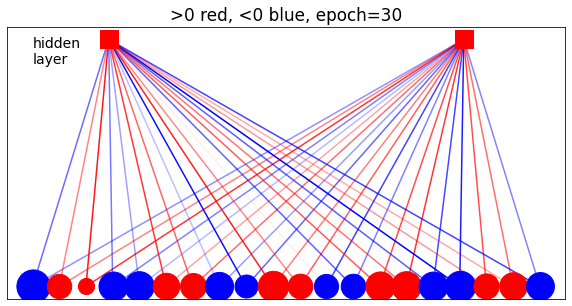

l_rate =  0.7692307692307697
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.32657104 -1.00078839]
EVALUATED ENERGIES =  [ 0.         11.78232224  4.76321096 -3.24854576] 

PROBABILITY :  [7.63151337e-06 9.99098259e-01 8.93813494e-04 2.96336516e-07] 

CUMULATIVE PROBABILITY :  [7.63151337e-06 9.99105890e-01 9.99999704e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-1.32657104 -1.00078839]
EVALUATED ENERGIES =  [-4.0402993   7.33957798  8.76692254  0.        ] 

PROBABILITY :  [2.21022352e-06 1.93488031e-01 8.06384123e-01 1.25636516e-04] 

CUMULATIVE PROBABILITY :  [2.21022352e-06 1.93490241e-01 9.99874363e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-1.32657104 -1.00078839]
EVALUATED ENERGIES =  [-4.78487892  4.03494523 12.21174757  0.        ] 

PROBABILITY :  [4.15273927e-08 2.81018960e-04 9.99713969e-01 4.97028366e-06] 

CUMULATIVE PROBABILITY :  [4.15273927e-08 2.81060488e-04 9.99995030e-01 1.00000000e+00

----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-1.46030481 -1.13103806]
EVALUATED ENERGIES =  [-12.28316807   0.           4.43192806  -4.13808193] 

PROBABILITY :  [5.43889385e-08 1.17495895e-02 9.88062910e-01 1.87446159e-04] 

CUMULATIVE PROBABILITY :  [5.43889385e-08 1.17496439e-02 9.99812554e-01 1.00000000e+00] 


----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-1.46030481 -1.13103806]
EVALUATED ENERGIES =  [-4.43227946  8.07776922  9.62003686  0.        ] 

PROBABILITY :  [6.50056682e-07 1.76196117e-01 8.23748548e-01 5.46846878e-05] 

CUMULATIVE PROBABILITY :  [6.50056682e-07 1.76196767e-01 9.99945315e-01 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-1.46191214 -1.13260269]
EVALUATED ENERGIES =  [-3.11324283  3.95354103 13.47063915  0.        ] 

PROBABILITY :  [6.27594273e-08 7.35773615e-05 9.99924948e-01 1.41170240e-06] 

CUMULATIVE PROBABILITY :  [6.27594273e-08 7.36401209e-05 9.99998588e-01 1.00000000e+00] 


----initiating ba

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.61510879 -1.28122738]
EVALUATED ENERGIES =  [-8.45024558  4.37797628 10.61148953  0.        ] 

PROBABILITY :  [5.25692112e-09 1.95865266e-03 9.98016760e-01 2.45825249e-05] 

CUMULATIVE PROBABILITY :  [5.25692112e-09 1.95865792e-03 9.99975417e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-1.61510879 -1.28122738]
EVALUATED ENERGIES =  [-3.56133532  9.61885958  4.92500734 -4.58749297] 

PROBABILITY :  [1.87049550e-06 9.90929105e-01 9.06835384e-03 6.70350696e-07] 

CUMULATIVE PROBABILITY :  [1.87049550e-06 9.90930976e-01 9.99999330e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-1.61510879 -1.28122738]
EVALUATED ENERGIES =  [-3.93282933  5.60677771  9.01345745 -5.47322321] 

PROBABILITY :  [2.30852208e-06 3.20872673e-02 9.67909929e-01 4.94708614e-07] 

CUMULATIVE PROBABILITY :  [2.30852208e-06 3.20895758e-02 9.99999505e-01 1.00000000e+00] 


----------- epoch = 39  

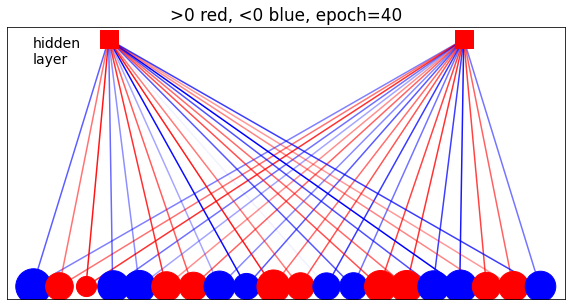

l_rate =  0.7142857142857149
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.64572273 -1.31130228]
EVALUATED ENERGIES =  [ 0.         10.58890066  9.20586518 -5.56555654] 

PROBABILITY :  [2.01417243e-05 7.99461905e-01 2.00517876e-01 7.70914392e-08] 

CUMULATIVE PROBABILITY :  [2.01417243e-05 7.99482047e-01 9.99999923e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-1.64572273 -1.31130228]
EVALUATED ENERGIES =  [ -4.02366801   5.69031136   6.01673144 -12.60701651] 

PROBABILITY :  [2.53274451e-05 4.19101310e-01 5.80873358e-01 4.74122418e-09] 

CUMULATIVE PROBABILITY :  [2.53274451e-05 4.19126638e-01 9.99999995e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-1.64572273 -1.31130228]
EVALUATED ENERGIES =  [-4.02366801  5.69031136 10.80667545 -5.47155843] 

PROBABILITY :  [3.60301818e-07 5.96202906e-03 9.94037526e-01 8.46945825e-08] 

CUMULATIVE PROBABILITY :  [3.60301818e-07 5.96238937e-03 9.99999915e-01 1.00000000

----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-1.76631363 -1.42955567]
EVALUATED ENERGIES =  [  0.          11.23879822   0.         -19.26544227] 

PROBABILITY :  [1.31534757e-05 9.99973693e-01 1.31534757e-05 5.65151987e-14] 

CUMULATIVE PROBABILITY :  [1.31534757e-05 9.99986847e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-1.76631363 -1.42955567]
EVALUATED ENERGIES =  [ -6.12386506   5.22424944   5.17429739 -11.76417631] 

PROBABILITY :  [6.04303862e-06 5.12482309e-01 4.87511627e-01 2.14634396e-08] 

CUMULATIVE PROBABILITY :  [6.04303862e-06 5.12488352e-01 9.99999979e-01 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-1.76778929 -1.43095413]
EVALUATED ENERGIES =  [ 0.         20.64864347  6.17641554  0.        ] 

PROBABILITY :  [1.07747663e-09 9.99999479e-01 5.18550485e-07 1.07747663e-09] 

CUMULATIVE PROBABILITY :  [1.07747663e-09 9.99999480e-01 9.99999999e-01 1.00000000e+00] 


----initiatin

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-1.88141187 -1.54133538]
EVALUATED ENERGIES =  [-10.01405135   5.09983649   5.772586    -5.3580354 ] 

PROBABILITY :  [9.22320815e-08 3.37878143e-01 6.62112060e-01 9.70429622e-06] 

CUMULATIVE PROBABILITY :  [9.22320815e-08 3.37878235e-01 9.99990296e-01 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-1.88285787 -1.54275173]
EVALUATED ENERGIES =  [-11.20872185   5.28093955  10.70682096   0.        ] 

PROBABILITY :  [3.02192576e-10 4.38180195e-03 9.95595905e-01 2.22930679e-05] 

CUMULATIVE PROBABILITY :  [3.02192576e-10 4.38180225e-03 9.99977707e-01 1.00000000e+00] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.90856931 -1.56789012]
EVALUATED ENERGIES =  [-11.36329464   0.          17.72001027   0.        ] 

PROBABILITY :  [2.34035180e-13 2.01510325e-08 9.99999960e-01 2.01510325e-08] 

CUMULATIVE PROBABILITY :  [2.34035180e-13 2.01512665e-08 9.99999980e-01 1.00000000e+00] 


----initiat

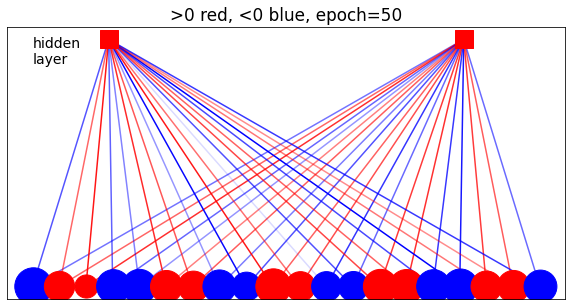

l_rate =  0.6666666666666671
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-1.93674864 -1.59485346]
EVALUATED ENERGIES =  [  0.          16.79167716   0.         -10.51455219] 

PROBABILITY :  [5.09879117e-08 9.99999898e-01 5.09879117e-08 1.38374234e-12] 

CUMULATIVE PROBABILITY :  [5.09879117e-08 9.99999949e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-1.93674864 -1.59485346]
EVALUATED ENERGIES =  [-10.33396728   5.24815042  12.66525326   0.        ] 

PROBABILITY :  [1.02636818e-10 6.00524748e-04 9.99396318e-01 3.15709858e-06] 

CUMULATIVE PROBABILITY :  [1.02636818e-10 6.00524851e-04 9.99996843e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-1.93674864 -1.59485346]
EVALUATED ENERGIES =  [  0.          16.79167716   0.         -10.51455219] 

PROBABILITY :  [5.09879117e-08 9.99999898e-01 5.09879117e-08 1.38374234e-12] 

CUMULATIVE PROBABILITY :  [5.09879117e-08 9.99999949e-01 1.00000000e+00 1.

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-2.04578125 -1.7035107 ]
EVALUATED ENERGIES =  [-4.82398925 11.9682961   7.07358477 -5.31679517] 

PROBABILITY :  [5.05782790e-08 9.92569474e-01 7.43044451e-03 3.08987677e-08] 

CUMULATIVE PROBABILITY :  [5.05782790e-08 9.92569525e-01 9.99999969e-01 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-2.04709516 -1.7048095 ]
EVALUATED ENERGIES =  [-6.97901327  5.98189142 12.98467172 -8.35691439] 

PROBABILITY :  [2.13543828e-09 9.08524007e-04 9.99091473e-01 5.38359238e-10] 

CUMULATIVE PROBABILITY :  [2.13543828e-09 9.08526143e-04 9.99999999e-01 1.00000000e+00] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.0709341 -1.7284675]
EVALUATED ENERGIES =  [ -6.52982576  12.28275804   0.         -11.30479656] 

PROBABILITY :  [6.75766492e-09 9.99995362e-01 4.63088449e-06 5.70234096e-11] 

CUMULATIVE PROBABILITY :  [6.75766492e-09 9.99995369e-01 1.00000000e+00 1.00000000e+00] 


----initiating backwa

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.17551519 -1.83088937]
EVALUATED ENERGIES =  [ -6.54969359   6.0779812    7.49469328 -14.44524951] 

PROBABILITY :  [6.40177030e-07 1.95177418e-01 8.04821942e-01 2.38398610e-10] 

CUMULATIVE PROBABILITY :  [6.40177030e-07 1.95178058e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.17551519 -1.83088937]
EVALUATED ENERGIES =  [ -5.61315542   7.12273421   7.7139893  -15.79632397] 

PROBABILITY :  [1.04892872e-06 3.56346556e-01 6.43652395e-01 3.96508102e-11] 

CUMULATIVE PROBABILITY :  [1.04892872e-06 3.56347605e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.17551519 -1.83088937]
EVALUATED ENERGIES =  [-19.82261749   0.          13.80994046   0.        ] 

PROBABILITY :  [2.47494071e-15 1.00558362e-06 9.99997989e-01 1.00558362e-06] 

CUMULATIVE PROBABILITY :  [2.47494071e-15 1.00558362e-06 9.99998994e-01 1.00000000e+00] 


----------- 

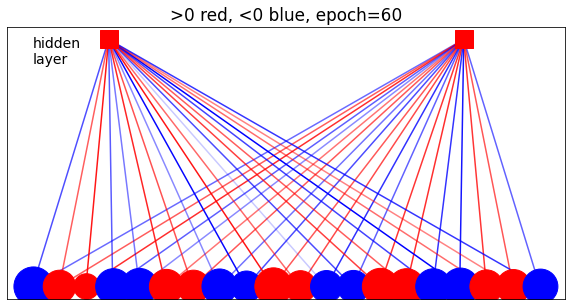

l_rate =  0.6250000000000006
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.20125037 -1.8562326 ]
EVALUATED ENERGIES =  [-10.97162311  14.03682758   6.56862897   0.        ] 

PROBABILITY :  [1.37632064e-11 9.99428569e-01 5.70629625e-04 8.01004578e-07] 

CUMULATIVE PROBABILITY :  [1.37632064e-11 9.99428569e-01 9.99999199e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.20125037 -1.8562326 ]
EVALUATED ENERGIES =  [ 0.          5.97134761 20.78016499 -6.29435121] 

PROBABILITY :  [9.44688982e-10 3.70349845e-07 9.99999629e-01 1.74456378e-12] 

CUMULATIVE PROBABILITY :  [9.44688982e-10 3.71294534e-07 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.20125037 -1.8562326 ]
EVALUATED ENERGIES =  [ -7.45014449   6.39765061   7.79626846 -15.95192759] 

PROBABILITY :  [1.91744110e-07 1.98035491e-01 8.01964317e-01 3.89443576e-11] 

CUMULATIVE PROBABILITY :  [1.91744110e-07 1.98035683e-01 1.00000000e+00 1.0000

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-2.30453974 -1.9561639 ]
EVALUATED ENERGIES =  [-5.9976143  14.58845348  8.12475712 -9.14003684] 

PROBABILITY :  [1.14526980e-09 9.98443403e-01 1.55659556e-03 4.94505403e-11] 

CUMULATIVE PROBABILITY :  [1.14526980e-09 9.98443404e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-2.3057809  -1.95739747]
EVALUATED ENERGIES =  [ 0.         12.67875916 13.65147274 -6.59805427] 

PROBABILITY :  [8.55014649e-07 2.74339724e-01 7.25659419e-01 1.16539995e-09] 

CUMULATIVE PROBABILITY :  [8.55014649e-07 2.74340579e-01 9.99999999e-01 1.00000000e+00] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.32843034 -1.97964558]
EVALUATED ENERGIES =  [-20.35030939   6.49038944   7.98511156   0.        ] 

PROBABILITY :  [4.03710969e-13 1.83163080e-01 8.16558886e-01 2.78033817e-04] 

CUMULATIVE PROBABILITY :  [4.03710969e-13 1.83163080e-01 9.99721966e-01 1.00000000e+00] 


----initiating back

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.42615021 -2.0754762 ]
EVALUATED ENERGIES =  [-20.80416852   0.           7.52977889  -6.95014173] 

PROBABILITY :  [4.94868342e-13 5.36568610e-04 9.99462917e-01 5.14300634e-07] 

CUMULATIVE PROBABILITY :  [4.94868342e-13 5.36568611e-04 9.99999486e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.42615021 -2.0754762 ]
EVALUATED ENERGIES =  [ 0.         21.54693519 14.18566427  0.        ] 

PROBABILITY :  [4.38539873e-10 9.99365012e-01 6.34986953e-04 4.38539873e-10] 

CUMULATIVE PROBABILITY :  [4.38539873e-10 9.99365013e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.42615021 -2.0754762 ]
EVALUATED ENERGIES =  [-7.29002827 13.32769528  8.30183362 -6.42163378] 

PROBABILITY :  [1.10406390e-09 9.93476900e-01 6.52309631e-03 2.63107447e-09] 

CUMULATIVE PROBABILITY :  [1.10406390e-09 9.93476901e-01 9.99999997e-01 1.00000000e+00] 


----------- epoch = 

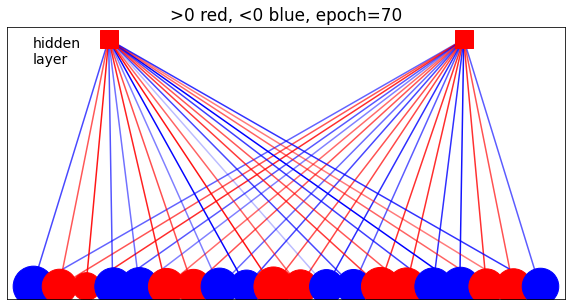

l_rate =  0.5882352941176475
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.45050883 -2.09923032]
EVALUATED ENERGIES =  [ -6.43343426   7.85923044   0.         -25.47133062] 

PROBABILITY :  [6.20306945e-07 9.99613358e-01 3.86021630e-04 3.34621087e-15] 

CUMULATIVE PROBABILITY :  [6.20306945e-07 9.99613978e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.45050883 -2.09923032]
EVALUATED ENERGIES =  [-7.64182016 14.33125715  8.3813866  -6.49095491] 

PROBABILITY :  [2.85813933e-10 9.97400595e-01 2.59940336e-03 9.03436897e-10] 

CUMULATIVE PROBABILITY :  [2.85813933e-10 9.97400596e-01 9.99999999e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.45050883 -2.09923032]
EVALUATED ENERGIES =  [ -8.20469448   7.06003084   0.         -25.47133062] 

PROBABILITY :  [2.34553076e-07 9.99141751e-01 8.58014586e-04 7.43766026e-15] 

CUMULATIVE PROBABILITY :  [2.34553076e-07 9.99141985e-01 1.00000000e+00 1.0000

----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-2.54640477 -2.19392627]
EVALUATED ENERGIES =  [ 0.         15.43187985 16.18606861 -9.87254538] 

PROBABILITY :  [6.35399023e-08 3.19909258e-01 6.80090678e-01 3.27683491e-12] 

CUMULATIVE PROBABILITY :  [6.35399023e-08 3.19909322e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-2.54640477 -2.19392627]
EVALUATED ENERGIES =  [-15.21671615   0.           0.         -26.3405794 ] 

PROBABILITY :  [1.23149909e-07 4.99999938e-01 4.99999938e-01 1.81719557e-12] 

CUMULATIVE PROBABILITY :  [1.23149909e-07 5.00000062e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-2.54758535 -2.19507496]
EVALUATED ENERGIES =  [-7.92862477 14.84917525  8.69682592 -6.77497172] 

PROBABILITY :  [1.27880327e-10 9.97876045e-01 2.12395462e-03 4.05348800e-10] 

CUMULATIVE PROBABILITY :  [1.27880327e-10 9.97876045e-01 1.00000000e+00 1.00000000e+00] 


----initiating ba

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.65973588 -2.30651676]
EVALUATED ENERGIES =  [-15.90196526   0.          15.69153079  -8.66496584] 

PROBABILITY :  [1.90159898e-14 1.53198565e-07 9.99999847e-01 2.64306503e-11] 

CUMULATIVE PROBABILITY :  [1.90159898e-14 1.53198584e-07 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.65973588 -2.30651676]
EVALUATED ENERGIES =  [ -8.84097783   0.          17.56159862 -18.70460177] 

PROBABILITY :  [3.41591246e-12 2.36099255e-08 9.99999976e-01 1.77741681e-16] 

CUMULATIVE PROBABILITY :  [3.41591246e-12 2.36133415e-08 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.65973588 -2.30651676]
EVALUATED ENERGIES =  [-8.2608936  23.06993305  0.         -7.63621835] 

PROBABILITY :  [2.47283348e-14 1.00000000e+00 9.56875376e-11 4.61836110e-14] 

CUMULATIVE PROBABILITY :  [2.47283348e-14 1.00000000e+00 1.00000000e+00 1.00000000e+00] 


----------- epoc

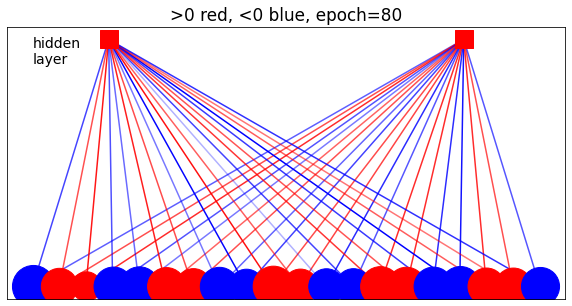

l_rate =  0.555555555555556
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.68266309 -2.32895271]
EVALUATED ENERGIES =  [ -8.90955842   7.67595567   8.11827366 -17.29045736] 

PROBABILITY :  [2.45125860e-08 3.91188769e-01 6.08811207e-01 5.61837813e-12] 

CUMULATIVE PROBABILITY :  [2.45125860e-08 3.91188793e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.68266309 -2.32895271]
EVALUATED ENERGIES =  [-8.32855935 15.57094417 17.49961226  0.        ] 

PROBABILITY :  [5.29703113e-12 1.26898072e-01 8.73101906e-01 2.19320837e-08] 

CUMULATIVE PROBABILITY :  [5.29703113e-12 1.26898072e-01 9.99999978e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.68266309 -2.32895271]
EVALUATED ENERGIES =  [-15.18327986   8.47639483   8.11827366  -8.73426642] 

PROBABILITY :  [3.12279464e-11 5.88585536e-01 4.11414444e-01 1.97385104e-08] 

CUMULATIVE PROBABILITY :  [3.12279464e-11 5.88585536e-01 9.99999980e-01 1.00000

----initiating backward CD: k =  600 ----
WEIGHTS[0] :  [-2.77151531 -2.41808755]
EVALUATED ENERGIES =  [-16.57957304   0.          17.65028262 -10.55624046] 

PROBABILITY :  [1.36195437e-15 2.16062623e-08 9.99999978e-01 5.62422470e-13] 

CUMULATIVE PROBABILITY :  [1.36195437e-15 2.16062636e-08 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-2.77151531 -2.41808755]
EVALUATED ENERGIES =  [  0.          16.63006124   0.         -28.38856415] 

PROBABILITY :  [5.99316340e-08 9.99999880e-01 5.99316340e-08 2.80969616e-20] 

CUMULATIVE PROBABILITY :  [5.9931634e-08 9.9999994e-01 1.0000000e+00 1.0000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-2.77260737 -2.41918357]
EVALUATED ENERGIES =  [-15.29444746   7.4989283   18.09331895   0.        ] 

PROBABILITY :  [3.16130499e-15 2.50555368e-05 9.99974931e-01 1.38726852e-08] 

CUMULATIVE PROBABILITY :  [3.16130499e-15 2.50555368e-05 9.99999986e-01 1.00000000e+00] 


----initiatin

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.87797764 -2.52457368]
EVALUATED ENERGIES =  [  0.          17.19648883   8.35657194 -20.21632953] 

PROBABILITY :  [3.40092366e-08 9.99855152e-01 1.44813805e-04 5.64620347e-17] 

CUMULATIVE PROBABILITY :  [3.40092366e-08 9.99855186e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.87797764 -2.52457368]
EVALUATED ENERGIES =  [-17.55389118  16.15564022   9.78066682   0.        ] 

PROBABILITY :  [2.28769025e-15 9.98299136e-01 1.70076742e-03 9.61513302e-08] 

CUMULATIVE PROBABILITY :  [2.28769025e-15 9.98299136e-01 9.99999904e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.87797764 -2.52457368]
EVALUATED ENERGIES =  [-16.19417829   8.66123831   9.78066682  -7.74922141] 

PROBABILITY :  [3.94977053e-12 2.46117300e-01 7.53882682e-01 1.83725755e-08] 

CUMULATIVE PROBABILITY :  [3.94977053e-12 2.46117300e-01 9.99999982e-01 1.00000000e+00] 


----------- 

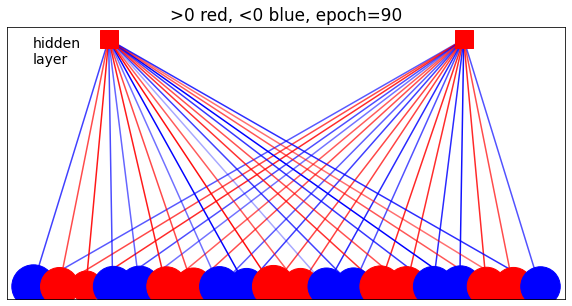

l_rate =  0.5263157894736847
----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-2.89965654 -2.54552419]
EVALUATED ENERGIES =  [ -7.78412856   9.05553233  10.05646491 -20.15484276] 

PROBABILITY :  [1.30614010e-08 2.68758100e-01 7.31241887e-01 5.53932505e-14] 

CUMULATIVE PROBABILITY :  [1.30614010e-08 2.68758113e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-2.89965654 -2.54552419]
EVALUATED ENERGIES =  [-8.70533393 15.85159361 18.92551988  0.        ] 

PROBABILITY :  [9.55964241e-13 4.41956749e-02 9.55804319e-01 5.76926033e-09] 

CUMULATIVE PROBABILITY :  [9.55964241e-13 4.41956749e-02 9.99999994e-01 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-2.89965654 -2.54552419]
EVALUATED ENERGIES =  [-17.67986358   8.01636733  18.92551988   0.        ] 

PROBABILITY :  [1.26612332e-16 1.82897301e-05 9.99981704e-01 6.03591620e-09] 

CUMULATIVE PROBABILITY :  [1.26612332e-16 1.82897301e-05 9.99999994e-01 1.0000

----initiating backward CD: k =  800 ----
WEIGHTS[0] :  [-2.98531932 -2.62975246]
EVALUATED ENERGIES =  [  0.          17.75203711  10.33258255 -20.66658385] 

PROBABILITY :  [1.95041918e-08 9.99400864e-01 5.99116863e-04 2.06416605e-17] 

CUMULATIVE PROBABILITY :  [1.95041918e-08 9.99400883e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  1000 ----
WEIGHTS[0] :  [-2.9863333  -2.63074691]
EVALUATED ENERGIES =  [-9.23042083 17.18717032  9.35682714 -8.6003489 ] 

PROBABILITY :  [3.36366970e-12 9.99602669e-01 3.97331111e-04 6.31611610e-12] 

CUMULATIVE PROBABILITY :  [3.36366970e-12 9.99602669e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-3.00503664 -2.64894981]
EVALUATED ENERGIES =  [-25.95998314   0.           0.         -16.77577629] 

PROBABILITY :  [2.65884221e-12 4.99999987e-01 4.99999987e-01 2.59025738e-08] 

CUMULATIVE PROBABILITY :  [2.65884221e-12 4.99999987e-01 9.99999974e-01 1.00000000e+00] 


----initiating 

----initiating backward CD: k =  0 ----
WEIGHTS[0] :  [-3.08663065 -2.7293384 ]
EVALUATED ENERGIES =  [-9.52911414 17.71508909 20.14369449  0.        ] 

PROBABILITY :  [1.19280737e-13 8.10172393e-02 9.18982759e-01 1.64063511e-09] 

CUMULATIVE PROBABILITY :  [1.19280737e-13 8.10172393e-02 9.99999998e-01 1.00000000e+00] 


----initiating backward CD: k =  200 ----
WEIGHTS[0] :  [-3.08663065 -2.7293384 ]
EVALUATED ENERGIES =  [ -8.34407985   9.54735212   9.02993982 -21.47391488] 

PROBABILITY :  [1.06365390e-08 6.26542469e-01 3.73457521e-01 2.11147253e-14] 

CUMULATIVE PROBABILITY :  [1.06365390e-08 6.26542479e-01 1.00000000e+00 1.00000000e+00] 


----initiating backward CD: k =  400 ----
WEIGHTS[0] :  [-3.08663065 -2.7293384 ]
EVALUATED ENERGIES =  [  0.          26.60974428   0.         -19.73001717] 

PROBABILITY :  [2.77673795e-12 1.00000000e+00 2.77673795e-12 7.49716917e-21] 

CUMULATIVE PROBABILITY :  [2.77673795e-12 1.00000000e+00 1.00000000e+00 1.00000000e+00] 


----------- epoc

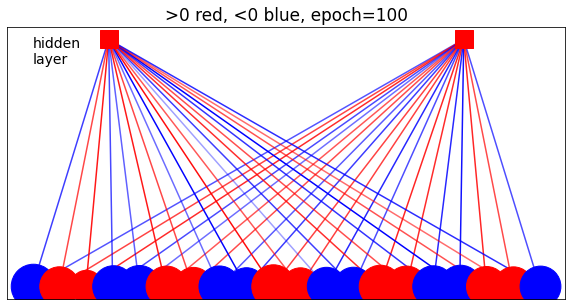

l_rate =  0.5000000000000009


In [90]:
# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

# learning rate
l_rate = 1.0

# initialize Adam 
beta1=0.9
beta2=0.999
epsilon=1e-8
m_dw, v_dw = 0, 0
m_db, v_db = 0, 0
m_da, v_da = 0, 0
t=1

# minibatch
mini, m = 500, 0
steps=3
# train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))

        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        hf = h
        for i in range(steps):
            vf,_ = activate_back_again(v[k],hf,w.T,a,k,i)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP)
        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a Adam optimizer
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)       #removed l_rate_m (has to be used after)
            db = l_rate_m*(h_data - h_model)
            
            ##********update***********##
            m_dw = beta1*m_dw + (1-beta1)*(vh_data - vh_model)
            m_db = beta1*m_db + (1-beta1)*(h_data - h_model)
            m_da = beta1*m_da + (1-beta1)*(v_data - v_model)

            ## rms beta 2
            v_dw = beta2*v_dw + (1-beta2)*((vh_data - vh_model)**2)
            v_db = beta2*v_db + (1-beta2)*((h_data - h_model)**2)
            v_da = beta2*v_da + (1-beta2)*((v_data - v_model)**2)

            ## bias correction
            m_dw_corr = m_dw/(1-beta1**t)
            m_db_corr = m_db/(1-beta1**t)
            m_da_corr = m_da/(1-beta1**t)

            v_dw_corr = v_dw/(1-beta2**t)
            v_db_corr = v_db/(1-beta2**t)
            v_da_corr = v_da/(1-beta2**t)
            
            
            if epoch%10==9 and k<=mini:
                print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                print('dw =',dw)
                print('da =',da)
                print('db =',db)
                print('vh_data \n', vh_data, '\n')
                print('vh_model \n',vh_model)
                
            ## update weights and biases
            w = w - l_rate_m*(m_dw_corr/(np.sqrt(v_dw_corr)+epsilon))
            b = b - l_rate_m*(m_db_corr/(np.sqrt(v_db_corr)+epsilon))
            a = a - l_rate_m*(m_da_corr/(np.sqrt(v_da_corr)+epsilon))
            m=0
            t=t+1 #update the time
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1)
        print('l_rate = ',l_rate)


# Optional 5. plot the weights 


Plot the weights wiμ of each hidden unit μ
in an A×G table, with a color map preserving the
rule that red means positive and blue
means negative weight

In [14]:
print('w0=',w0);print('a0=',a0);print('b0=',b0)
print('w=',w);print('a=',a);print('b=',b)


w0= [[-8.72876393e-02  2.04222126e-01]
 [-2.21489412e-01 -2.36964198e-01]
 [ 8.38211653e-01  5.94150244e-01]
 [ 3.96160518e-02  1.20136963e-01]
 [ 3.27912325e-01  5.31481557e-01]
 [ 4.29466985e-01 -5.52710538e-01]
 [ 1.17256826e-01  9.76087795e-02]
 [ 5.76885677e-01  3.77974741e-01]
 [-8.53501017e-01 -1.58554191e-01]
 [ 7.11674783e-01 -1.87006764e-01]
 [-2.30146526e-01  2.03387092e-01]
 [ 1.38535434e+00 -4.35452880e-01]
 [-2.46070853e-01  5.29254898e-02]
 [ 1.29034856e-01  2.23337160e-01]
 [ 4.00935791e-04  5.73002421e-01]
 [-3.04256178e-01 -3.54405060e-01]
 [-1.01067017e+00 -7.93431066e-01]
 [-3.67028188e-01  2.38846755e-01]
 [-5.39796281e-01  5.10944576e-02]
 [-4.53483232e-01  1.41941667e-01]]
a0= [-1.00605956 -0.0850854  -0.6575091  -0.41392318 -0.55731957  0.12209994
  0.16117297 -0.3214583   0.14126068  0.57553201  0.02979552  0.10518219
 -0.0050578   0.4284531   0.56591768 -0.39197445 -0.6605412   0.00945954
  0.32336713 -0.28164852]
b0= [0. 0.]
w= [[-3.11732513 -2.75586699]
 [ 2

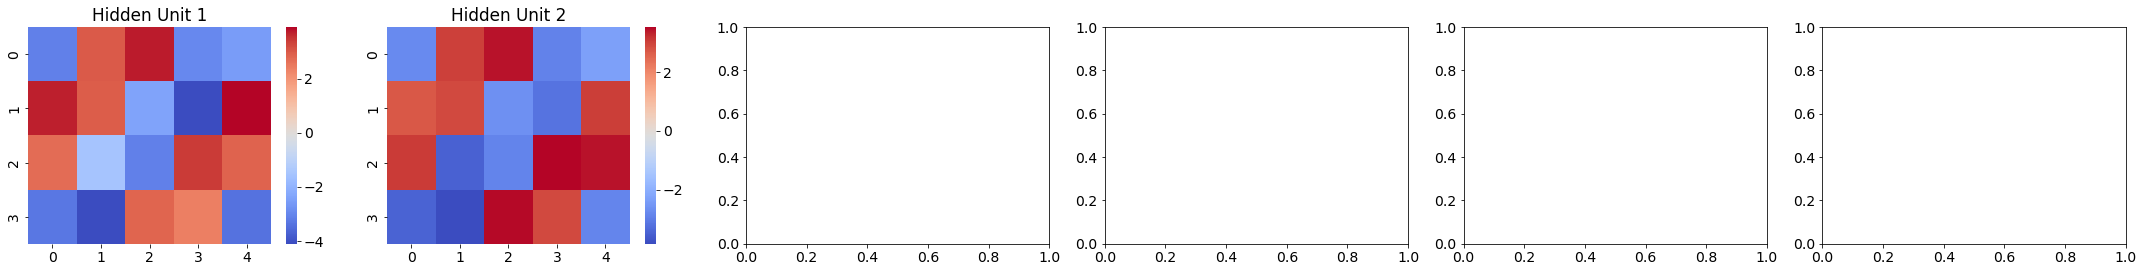

In [55]:
w1=[w[:,i].reshape(4,5) for i in range(M)]
import seaborn as sns

fig, axs = plt.subplots(ncols=6, figsize=(5*6,4))
for i in range(M):
    sns.heatmap(w1[i], cmap='coolwarm', annot=False, ax=axs[i])
    axs[i].set_title(f'Hidden Unit {i+1}')
    plt.tight_layout()
plt.show()

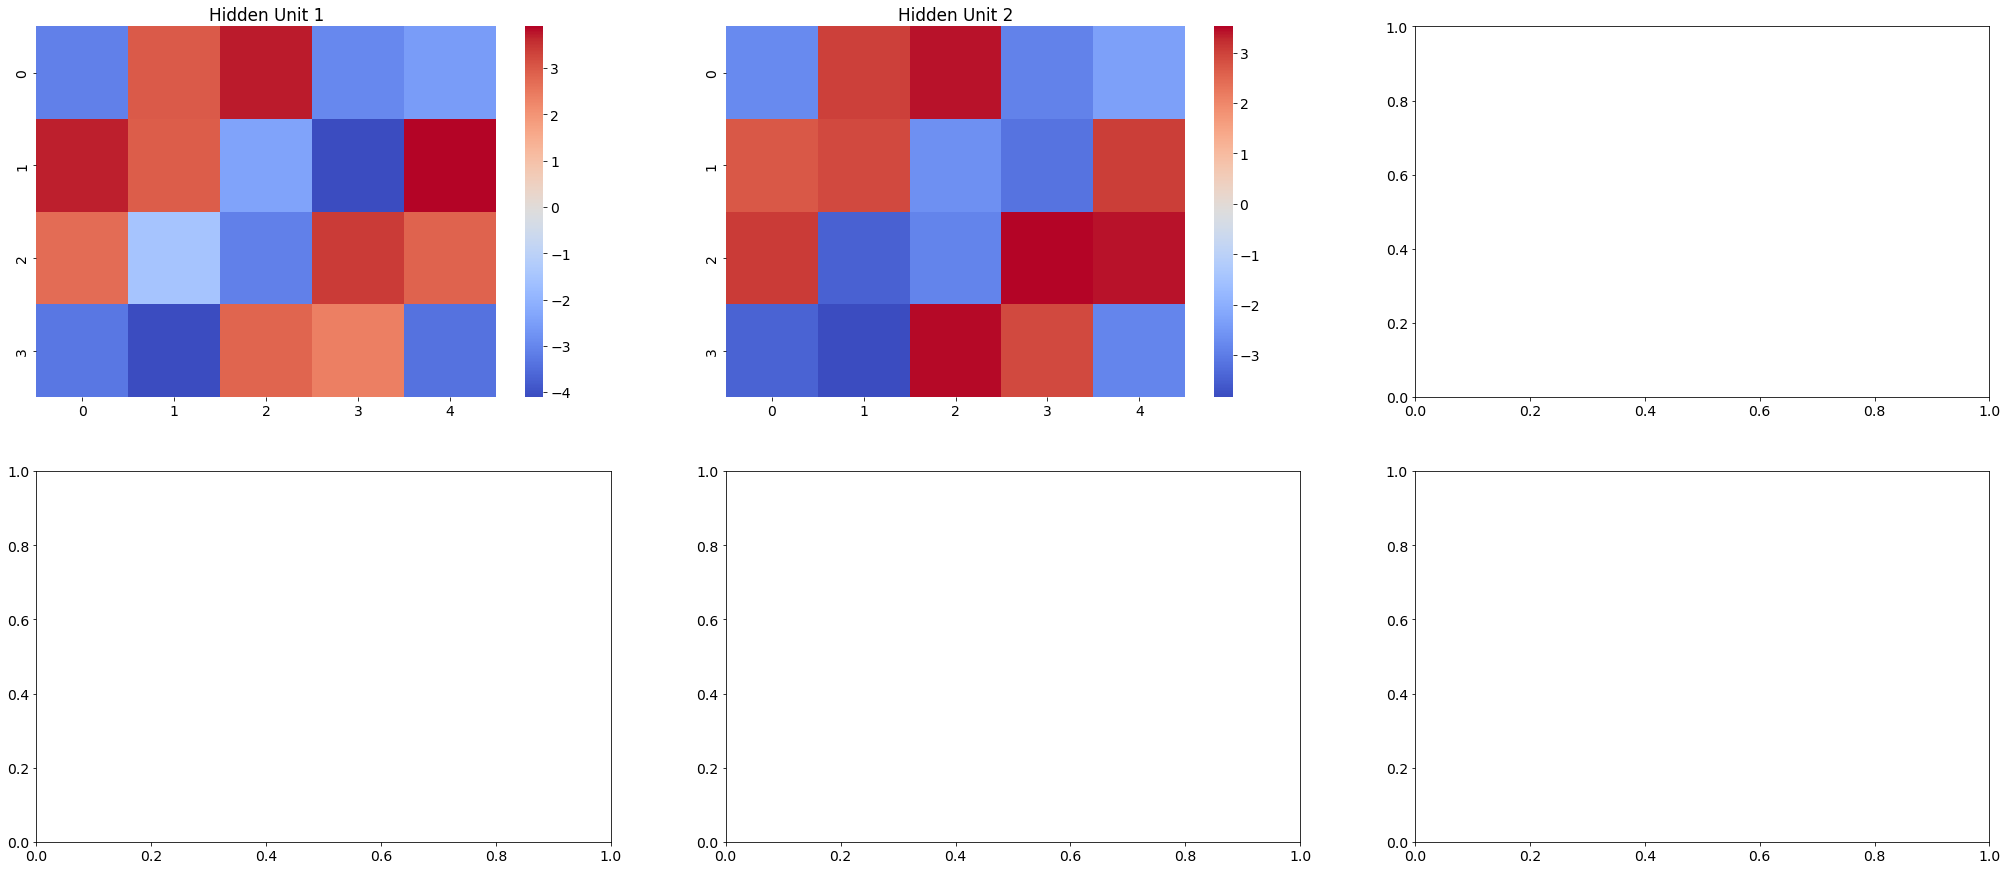

In [56]:
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(35,15))
for i in range(M):
    sns.heatmap(w1[i], cmap='coolwarm', annot=False, ax=axs.flat[i])
    axs.flat[i].set_title(f'Hidden Unit {i+1}')
plt.show()

